# Nuberu experimental results

## Reading data

In [1]:
data_file = "../nuberu-starter-lab/notebooks/all_requests_data.parquet"

In [2]:
# Read parquet file
import pandas as pd
data = pd.read_parquet(data_file)
data['injected'] = pd.to_datetime(data['injected'], unit='s', origin='2025-06-24 09:00:00')

## Summary of results



In [3]:
# Compute the percentage of finished requests for each app
percentage_pivot = data.pivot_table(
    index=['queue_size', 'termination', 'LB', 'distribution'],
    columns='app', values='finished', aggfunc=lambda x: x.sum() / len(x) * 100,
    fill_value=0).round(1)

# Append the cost of each experiment
cost_summary = data.groupby(['queue_size', 'termination', 'LB', 'distribution'])['cost'].first()
summary_with_cost = percentage_pivot.join(cost_summary)

summary_with_cost

app0   app1   cost
queue_size termination LB       distribution                     
0          drain       simple   poisson        68.4   68.1  10.65
                                trace         100.0   98.5  10.63
                       weighted poisson        51.7   50.1  10.65
                                trace          55.7   53.7  10.63
           hard        simple   poisson        68.4   68.1  10.62
                                trace         100.0   98.5  10.62
                       weighted poisson        51.7   50.0  10.62
                                trace          55.7   53.7  10.62
1000       drain       simple   poisson       100.0   99.6  16.55
                                trace         100.0   99.8  16.53
                       weighted poisson       100.0  100.0  11.09
                                trace         100.0  100.0  10.65
           hard        simple   poisson       100.0   99.1  10.62
                                trace         100.0   99.2  10.62
                       weighted poisson       100.0   98.8  10.62
                                trace         100.0   99.9  10.62

## Plots

In [4]:
import plotting_utils as pu
import matplotlib.pyplot as plt

## Injected workload plots

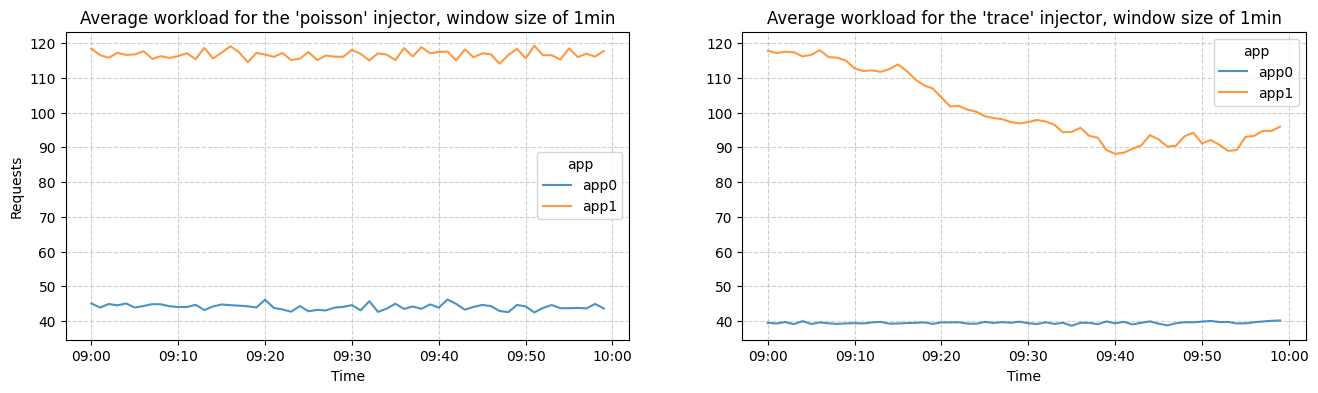

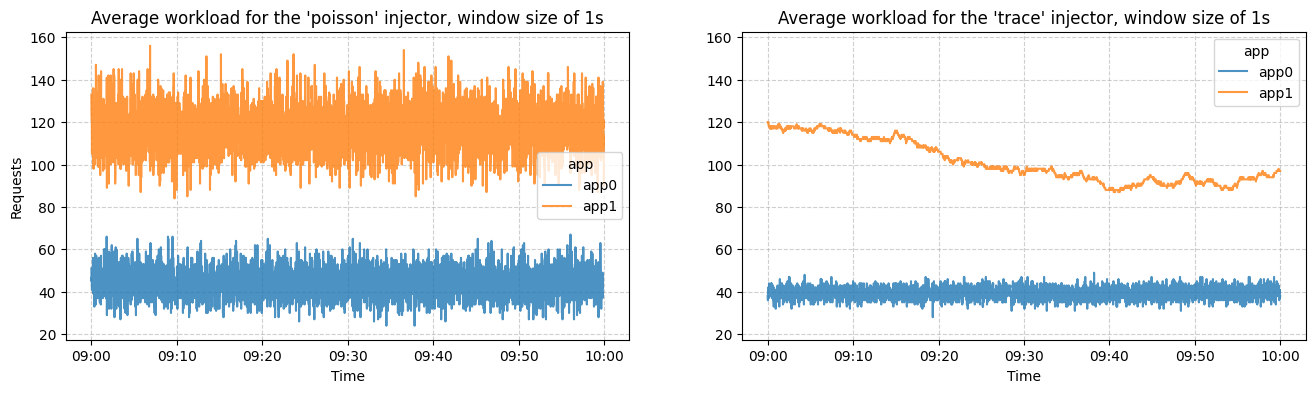

In [5]:
# Generate plots for injected requests in the two cases of injectors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
pu.plot_workloads(data, "poisson", "1min", ax=ax1)
pu.plot_workloads(data, "trace", "1min", ax=ax2)
ax2.tick_params(axis='y', labelleft=True) 

# Generate also plots for 1s window
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
pu.plot_workloads(data, "poisson", "1s", ax=ax1)
pu.plot_workloads(data, "trace", "1s", ax=ax2)
ax2.tick_params(axis='y', labelleft=True) 

## Response time example plots

Scenario:
- Trace based injector
- Drain pending requests at the end
- Random weighted load balancer
- Queue size 1000

Plot of average response time (60s window) per app, with error bars

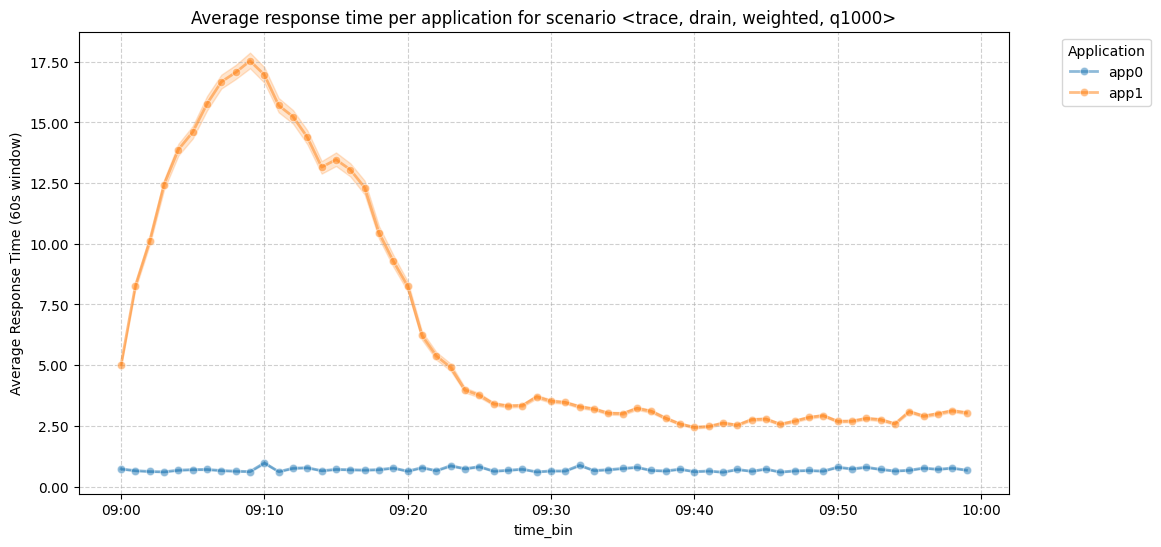

In [6]:
pu.plot_response_time(data, "trace", "drain", "weighted", "q1000");

Scenario: 
 - Trace based injector
 - Drain pending requests at the end
 - Random weighted load balancer
 - Queue size 1000

Plot of response times per container for app1, with error bars

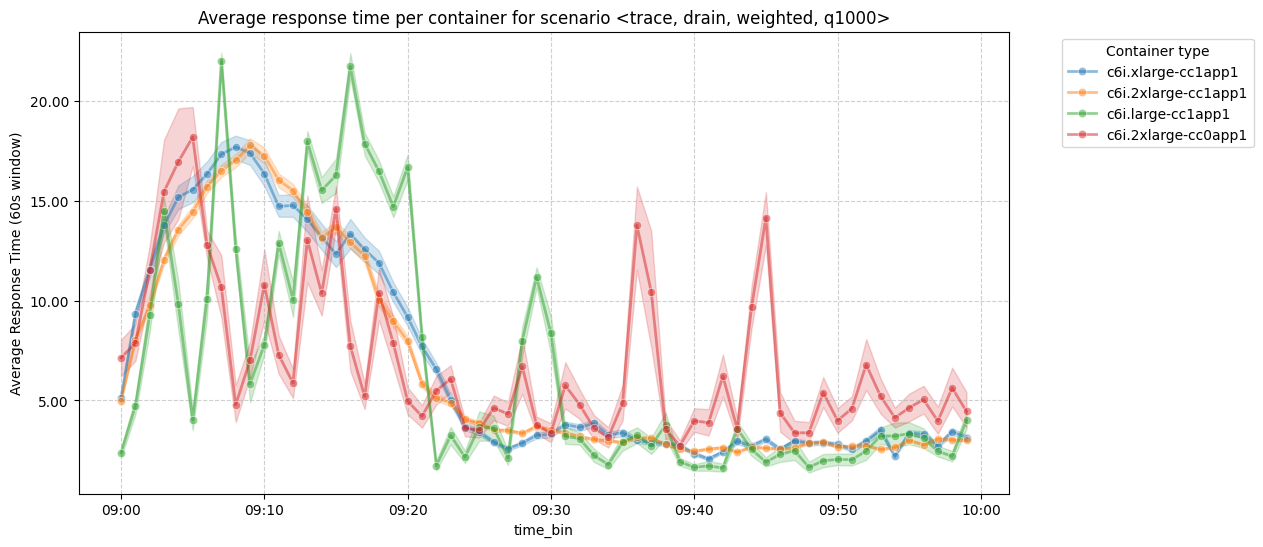

In [7]:
pu.plot_response_time(data, "trace", "drain", "weighted", "q1000", app="app1", grouper="ic-cc");

## Completed vs lost requests

**Scenario:**
- Trace based injector
- Drop pending requests at the end
- Random weighted load balancer
- Queue size 1000

Bar plot of completed and failed requests each 60s per app

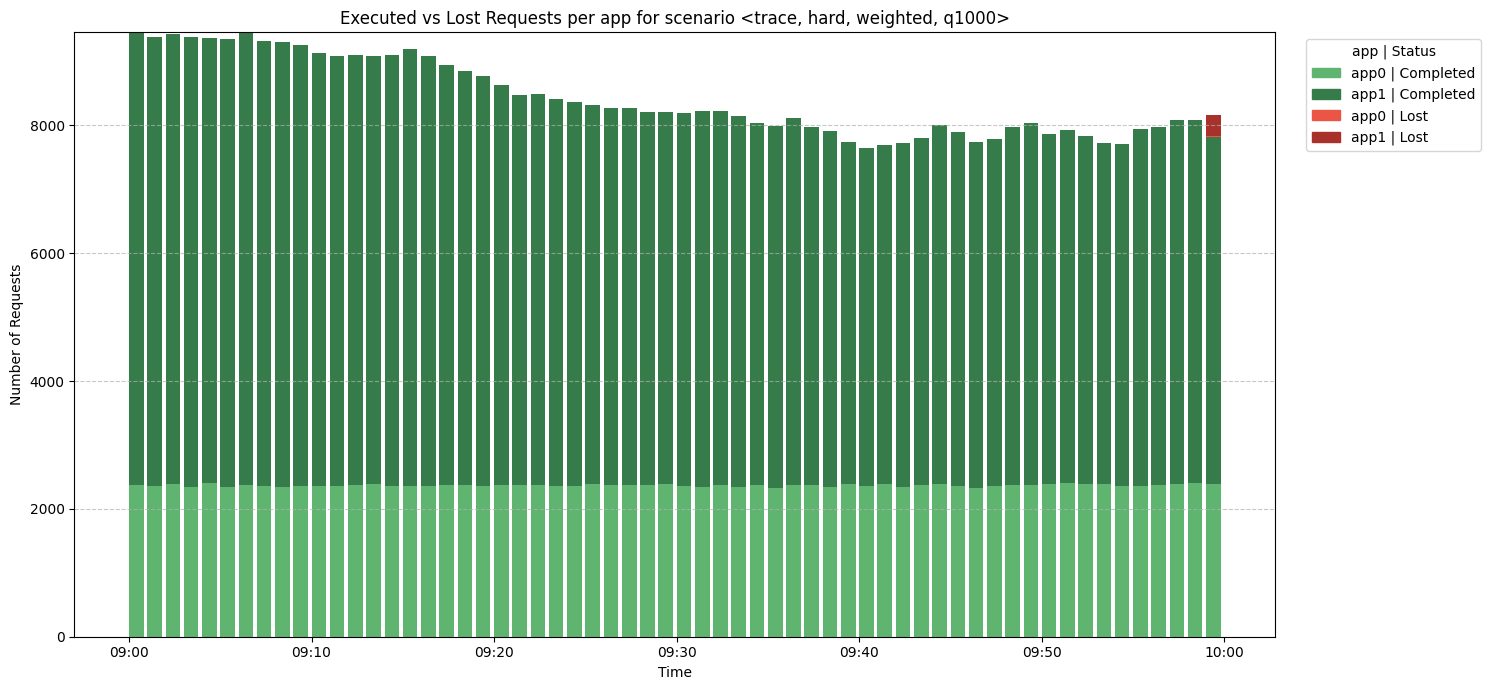

In [9]:
pu.plot_requests_success(data, "trace", "hard", "weighted", "q1000");

The above scenario uses queues large enough to store pending requests, so no requests are rejected. However, at the end of the experiment, there were pending requests in the queues (specially for app1), causing lost requests (dropped) at the end.

**Scenario:**
- Trace based injector
- Drain pending requests at the end
- Simple round-robin load balancer
- Queue size 0 (no queues)

Bar plot of completed and failed requests each 60s per app

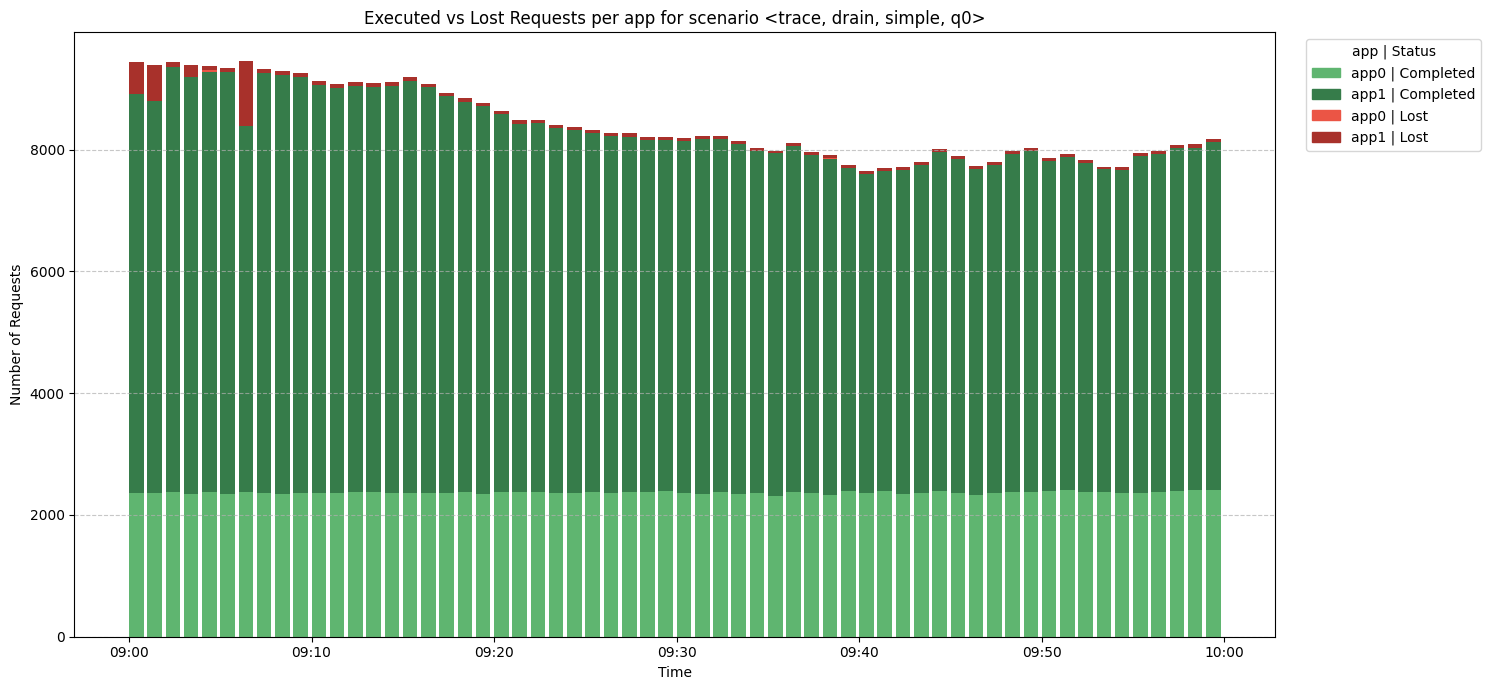

In [10]:
pu.plot_requests_success(data, "trace", "drain", "simple", "q0");

The above scenario does not use queues, so requests are rejected if they are delivered to a busy server. This causes a significant fraction of request to be dropped, especially for app1 at the beginning, since in that period of time the workload was larger than the p95 guaranteed by the allocation solver.

After the initial overload, a few requests are dropped at each minute, because the load balancer uses a simple round-robin algorithm which does not take into account the current load of each server. The allocation for app1 uses a few containers with low performance, but the load balancer send requests to those at the same rate as to the other containers, which have higher performance, causing the rejected requests.